In [3]:
%load_ext autoreload
%autoreload 2

In [22]:
from APT_coherence_T_utils import *

In [8]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Prefer the installed rqc package, not the local repo copy in control_transition
SITE_PACKAGES = '/p/home/hpan/.pyenv/versions/miniforge3-25.1.1-2/lib/python3.12/site-packages'
PROJECT_ROOT = os.path.expandvars('$WORKDIR/control_transition')
LOCAL_RQC = str(Path(PROJECT_ROOT) / 'rqc')

clean_sys_path = []
for p in sys.path:
    if p in ('', os.getcwd(), PROJECT_ROOT, LOCAL_RQC):
        continue
    if 'control_transition' in p and 'site-packages' not in p:
        continue
    clean_sys_path.append(p)
if SITE_PACKAGES not in clean_sys_path:
    clean_sys_path.insert(0, SITE_PACKAGES)
sys.path = clean_sys_path

if 'rqc' in sys.modules:
    del sys.modules['rqc']
importlib.invalidate_caches()
import rqc




In [5]:
os.environ['WORKDIR']="/scratch/hp636/"

In [10]:
data_dict_pf1 = load_apt_coherence(p_f=1, p_f_int=1, zipfilename='APT_coherence_T_pf1_6L.zip',
BATCH_CONFIG = {
    12: {'es_C_batch': 2000, 'num_batches': 2},
    14: {'es_C_batch': 2000, 'num_batches': 2},
    16: {'es_C_batch': 2000, 'num_batches': 2},
    18: {'es_C_batch': 2000, 'num_batches': 2},
    20: {'es_C_batch': 1000, 'num_batches': 4},
    22: {'es_C_batch': 24*10, 'num_batches': 4000//(24*10)+1},
    24: {'es_C_batch': 24*2, 'num_batches': 4000//(24*2)+1}
},
p_m_list =  np.hstack([np.arange(0, 0.06, 0.02), np.arange(0.06, 0.08, 0.01), np.arange(0.085, 0.101, 0.005),np.arange(0.11, 0.13, 0.01), ])
)

generate_params: 100%|██████████| 1092/1092 [00:04<00:00, 230.10it/s]


In [11]:
list(data_dict_pf1.keys())[-1]

('coherence',
 24,
 np.float64(0.13),
 np.float64(1.0),
 np.int64(4032),
 np.int64(1))

In [12]:
data_pf1_df = apt_coherence_to_df(data_dict_pf1)

In [32]:
data_pf1_df_mean=aggregate_over_samples(data_pf1_df)

In [33]:
data_pf1_df_mean.to_pickle('APT_coherence_T_pf1_6L_df.pickle')

In [34]:
print(data_pf1_df.head().to_string())

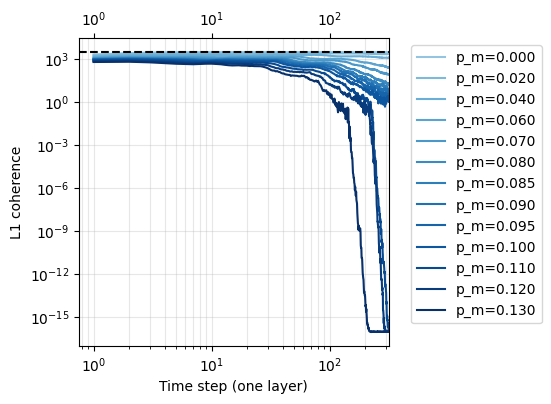

In [12]:
plot_apt_coherence_T_vs_steps_fixedL(data_pf1_df, L=12)


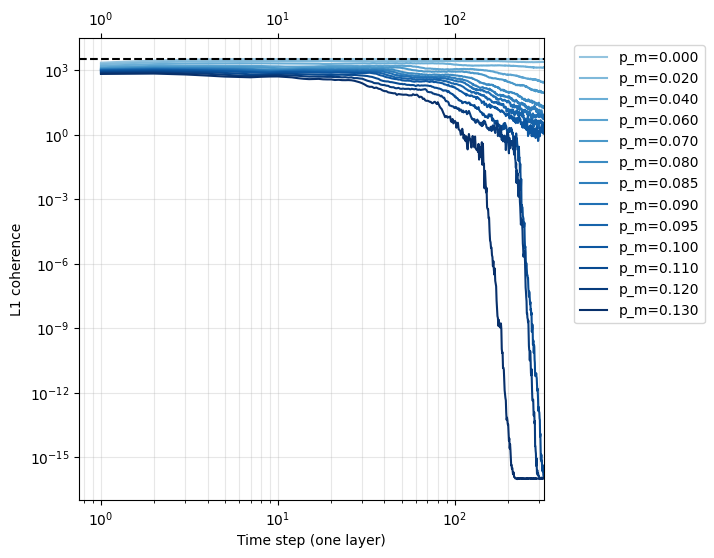

In [35]:
plot_apt_coherence_T_vs_steps_fixedL(data_pf1_df, L=12)


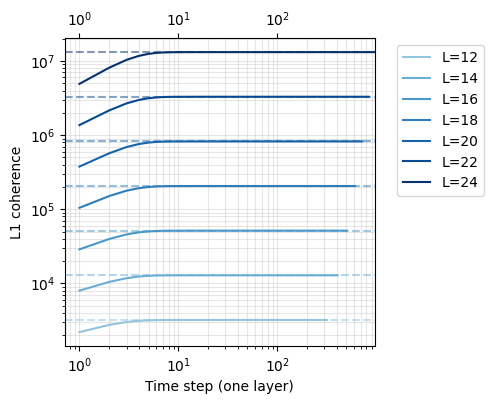

In [39]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.00)

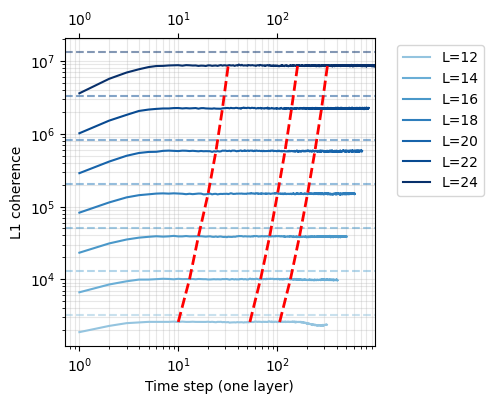

In [43]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.02, prefactor=[.2,1,2])

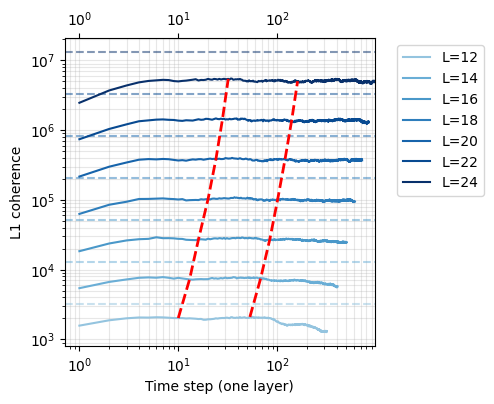

In [44]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.04, prefactor=[.2,1])

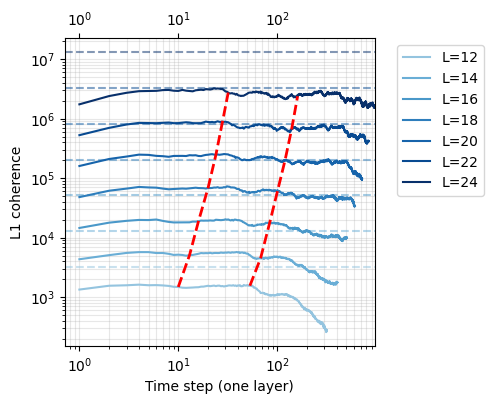

In [45]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.06, prefactor=[.2,1])

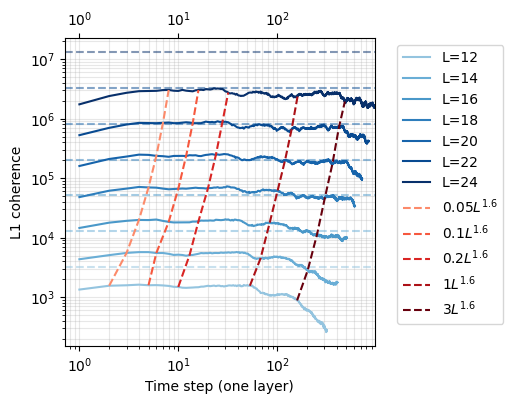

In [59]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.06, prefactor=[.05,.1,.2,1,3])

4000
4000
4000
4000
4000
4080
3744


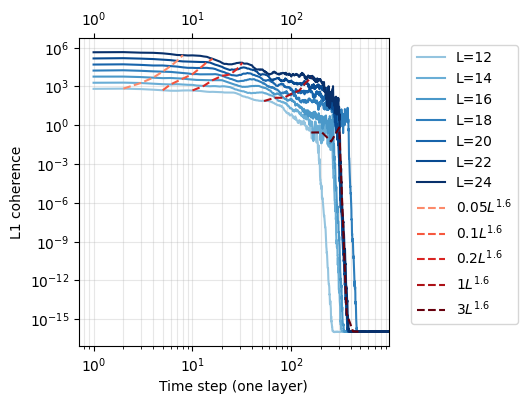

In [61]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.13, prefactor=[.05,.1,.2,1,3], theory_line=False)


4000
4000
4000
4000
4000
4080
3744


(1.0, 1000000.0)

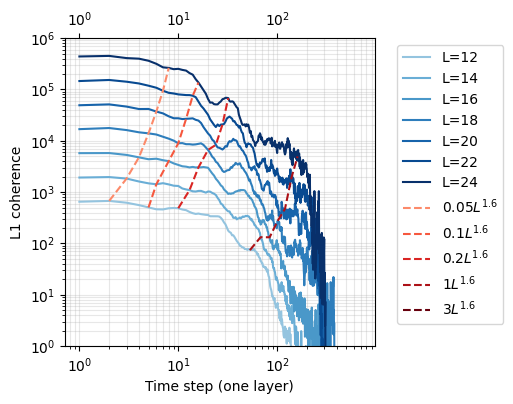

In [62]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.13, prefactor=[.05,.1,.2,1,3], theory_line=False)
plt.ylim(1e0,1e6)

4000
4000
4000
4000
4000
4080
3744


(1.0, 1000000.0)

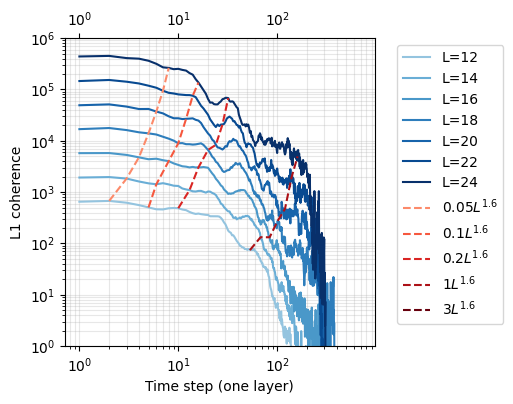

In [38]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.13, prefactor=[.05,.1,.2,1,3], theory_line=False)
plt.ylim(1e0,1e6)

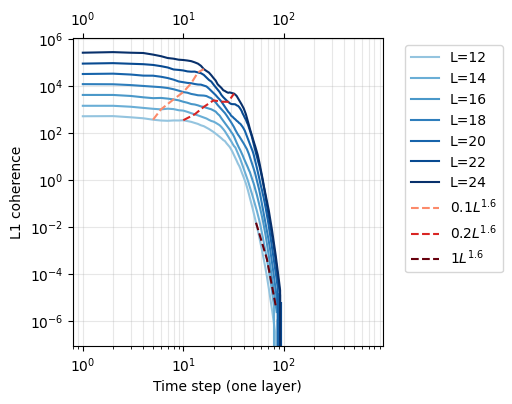

In [82]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.12, prefactor=[.1,.2,1,], average_log=True)

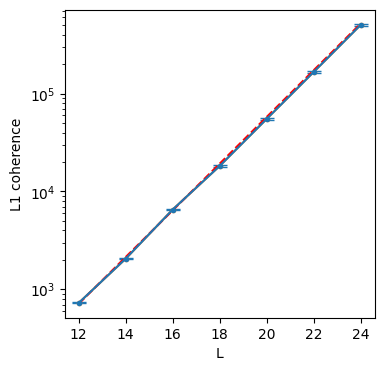

In [78]:
plot_apt_coherence_T_vs_L(data_pf1_df, p_m=0.11, min_func=lambda L: int(0.1*L**1.6), max_func=lambda L: int(0.1*L**1.6)+1, idx_max=3)

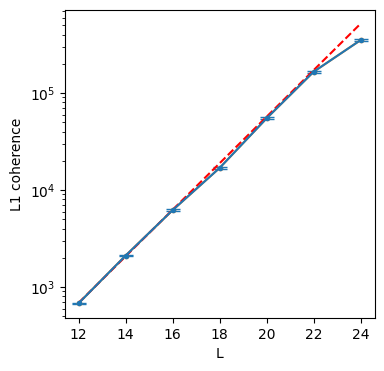

In [77]:
plot_apt_coherence_T_vs_L(data_pf1_df, p_m=0.11, min_func=lambda L: int(0.12*L**1.6), max_func=lambda L: int(0.12*L**1.6)+1, idx_max=3)

Text(0.5, 1.0, '$p_{m}=0.0$')

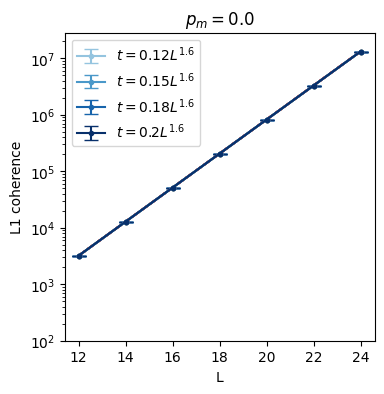

In [118]:
fig, ax =plt.subplots(figsize=(4, 4))
t_list = [0.12,0.15, 0.18, 0.2,]
color_list = plt.cm.Blues(np.linspace(0.4, 1, len(t_list)))
p_m  = 0.0
for idx,t in enumerate(t_list):
    plot_apt_coherence_T_vs_L(data_pf1_df, p_m=p_m, min_func=lambda L: int(t*L**1.6), max_func=lambda L: int(t*L**1.6)+1, idx_max=3, ax=ax, color = color_list[idx], label=f'$t={t}L^{{1.6}}$')
ax.legend()
ax.set_ylim(1e2,None)
ax.set_title(f'$p_{{m}}={p_m}$')    

Text(0.5, 1.0, '$t=0.2L^{1.6}$')

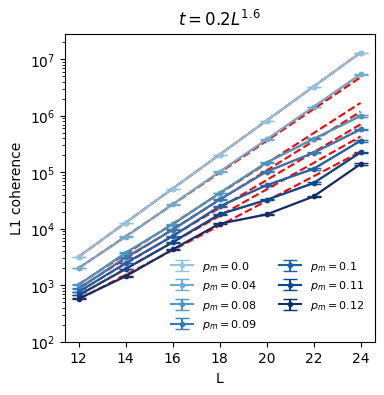

In [137]:
fig, ax =plt.subplots(figsize=(4, 4))
t=0.2
p_m_list  = [0.0, 0.04, 0.08, 0.09, 0.10,0.11,0.12]
color_list = plt.cm.Blues(np.linspace(0.4, 1, len(p_m_list)))
for idx,p_m in enumerate(p_m_list):
    plot_apt_coherence_T_vs_L(data_pf1_df, p_m=p_m, min_func=lambda L: int(t*L**1.6), max_func=lambda L: int(t*L**1.6)+1, idx_max=3, ax=ax, color = color_list[idx], label=f'$p_{{m}}={p_m}$')
ax.legend(ncols=2, fontsize=8,frameon=False)
ax.set_ylim(1e2,None)
ax.set_title(f'$t={t}L^{{1.6}}$')    

<>:9: SyntaxWarning: invalid escape sequence '\i'
<>:9: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_12483/2074251437.py:9: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'$t\in{t}L^{{1.6}}$')


Text(0.5, 1.0, '$t\\in[0.12, 0.2]L^{1.6}$')

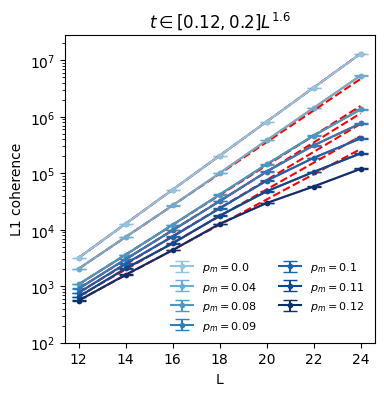

In [136]:
fig, ax =plt.subplots(figsize=(4, 4))
t=[0.12, 0.2]
p_m_list  = [0.0, 0.04, 0.08, 0.09, 0.10,0.11,0.12]
color_list = plt.cm.Blues(np.linspace(0.4, 1, len(p_m_list)))
for idx,p_m in enumerate(p_m_list):
    plot_apt_coherence_T_vs_L(data_pf1_df, p_m=p_m, min_func=lambda L: int(t[0]*L**1.6), max_func=lambda L: int(t[1]*L**1.6)+1, idx_max=3, ax=ax, color = color_list[idx], label=f'$p_{{m}}={p_m}$')
ax.legend(ncols=2, fontsize=8,frameon=False)
ax.set_ylim(1e2,None)
ax.set_title(f'$t\in{t}L^{{1.6}}$')    

<>:9: SyntaxWarning: invalid escape sequence '\i'
<>:9: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_12483/3299609506.py:9: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'$t\in{t}L^{{1.6}}$')


Text(0.5, 1.0, '$t\\in[0.12, 0.18]L^{1.6}$')

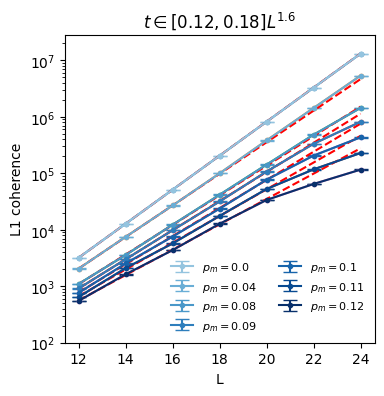

In [138]:
fig, ax =plt.subplots(figsize=(4, 4))
t=[0.12, 0.18]
p_m_list  = [0.0, 0.04, 0.08, 0.09, 0.10,0.11,0.12]
color_list = plt.cm.Blues(np.linspace(0.4, 1, len(p_m_list)))
for idx,p_m in enumerate(p_m_list):
    plot_apt_coherence_T_vs_L(data_pf1_df, p_m=p_m, min_func=lambda L: int(t[0]*L**1.6), max_func=lambda L: int(t[1]*L**1.6)+1, idx_max=3, ax=ax, color = color_list[idx], label=f'$p_{{m}}={p_m}$')
ax.legend(ncols=2, fontsize=8,frameon=False)
ax.set_ylim(1e2,None)
ax.set_title(f'$t\in{t}L^{{1.6}}$')    

In [ ]:
in slurm_out, i wnat to find a file which both contain `L 22` and `DUE TO TIME LIMIT`

In [1]:
384/24

16.0

In [2]:
10*60/16

37.5

In [ ]:
L=22

In [16]:
24*10, 2000//(24*10)+1

(240, 9)

In [ ]:
L=24

In [20]:
24*2, 2000//(24*2)+1

(48, 42)

In [ ]:
L=22 : 9:46:51/(384/24) = 

In [ ]:
L = 24 : 9:52:55/3 = 3h20

In [21]:
import numpy as np

In [23]:
len(np.hstack([np.arange(0, 0.06, 0.02), np.arange(0.06, 0.08, 0.01), np.arange(0.085, 0.101, 0.005),np.arange(0.11, 0.13, 0.01), ]))

13

In [4]:
from post_analysis_APT_fluct_T_all import run

In [5]:
run(12, 0.085, "OP")

  0%|          | 0/1 [00:00<?, ?it/s]

0.085 12


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


In [15]:
string ="""--L 12 --p_m 0.085 0.085 1 --p_f 1.0 1.0 1 --es 1 501 --es_C 1 51"""


In [17]:
print(' && '.join([f'python run_APT_OP_T.py {s}' for s in string.split('\n')]))

python run_APT_OP_T.py --L 12 --p_m 0.085 0.085 1 --p_f 1.0 1.0 1 --es 1 501 --es_C 1 51


In [ ]:
APT_En(1,501)_EnC(369,371)_pm(0.130,0.130,1)_pf(1.000,1.000,1)_L20_OP_T.pickle
'APT_En(1,501)_EnC(1,51)_pm(0.085,0.085,1)_pf(1.000,1.000,1)_L12_OP_T.pickle'

In [55]:
with open("/p/work/hpan/control_transition/APT_OP_T/APT_En(1,501)_EnC(101,151)_pm(0.085,0.085,1)_pf(1.000,1.000,1)_L12_OP_T.pickle", "rb") as f:
    data = pickle.load(f)

In [60]:
data['OP'][0,0,:,0,:]**2

array([[2.40765343e-01, 1.84856269e-01, 1.95168181e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.36003479e-01, 1.74934479e-01, 1.90951711e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.36003479e-01, 1.56195128e-01, 1.65601666e-01, ...,
        2.53950188e-76, 1.28423480e-77, 2.49768877e-77],
       ...,
       [2.48443894e-01, 1.89252544e-01, 2.28530407e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.48443894e-01, 1.80524204e-01, 1.85640631e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.88146514e-01, 1.49693511e-01, 1.75146490e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], shape=(500, 319))

In [58]:
data['OP'][0,0,:,0,:]

array([[4.90678452e-01, 4.29949147e-01, 4.41778430e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.85801893e-01, 4.18251693e-01, 4.36980218e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.85801893e-01, 3.95215293e-01, 4.06941846e-01, ...,
        1.59358146e-38, 3.58362219e-39, 4.99768823e-39],
       ...,
       [4.98441465e-01, 4.35031659e-01, 4.78048541e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.98441465e-01, 4.24881400e-01, 4.30860338e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.33758589e-01, 3.86902457e-01, 4.18505065e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], shape=(500, 319))

In [59]:
data['OP2'][0,0,:,0,:]

array([[2.40765343e-01, 1.84856269e-01, 1.95168181e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.36003479e-01, 1.74934479e-01, 1.90951711e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.36003479e-01, 1.56195128e-01, 1.65601666e-01, ...,
        2.53950188e-76, 1.28423480e-77, 2.49768877e-77],
       ...,
       [2.48443894e-01, 1.89252544e-01, 2.28530407e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.48443894e-01, 1.80524204e-01, 1.85640631e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.88146514e-01, 1.49693511e-01, 1.75146490e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], shape=(500, 319))

# Load 

In [18]:
%load_ext autoreload
%autoreload 2
import clifford_utils
import pickle
import numpy as np
import os
import rqc
import matplotlib.pyplot as plt
import fss

In [19]:
p_m_list = np.array([0.085,0.087,0.089,0.09,0.091,0.093,0.095, ])
L_list = [12,]


In [20]:
data_dict = {}
for p_m in p_m_list:
    for L in L_list:
        fn =  f'traj_state_var_{p_m:.3f}_OP_L{L}_APT.pickle'
        if os.path.exists(fn):
            with open(fn,'rb') as f:
                data_ = pickle.load(f)
                for key in data_:
                    data_dict[key, p_m, L] = data_[key][p_m, L]
                    if key == 'ob1_mean':
                        data_dict['n_def', p_m, L] = data_[key][p_m, L]

        else:
            print(f'File {fn} not found.')



In [21]:
data_df = rqc.convert_pd(data_dict, names=['Metrics', 'p_m', 'L'])

In [22]:
data_df.iloc[0]['observations'].shape

(532,)

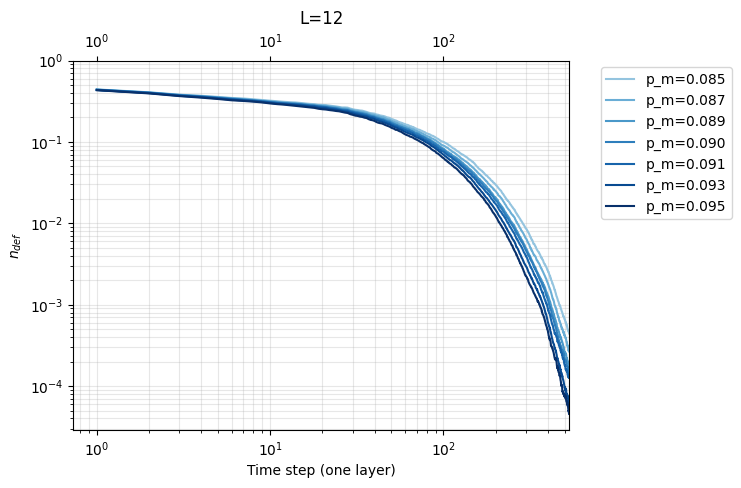

In [24]:
fig, ax = plt.subplots()
# y = data_df.xs(('n_def', 0.09, 12))['observations']
# x = np.arange(len(y))
# clifford_utils.simple_linearfit(x,y, xfunc=np.log, yfunc=np.log, ax=ax)

clifford_utils.plot_metric_T_vs_steps_fixedL( data_df, L=12, metric='n_def' ,ylabel='$n_{def}$', ylim=(None, 1), ax=ax)

# p_m_list=[0.66,.67,.69]
# clifford_utils.plot_metric_T_vs_steps_fixedL( data_df, L=64, metric='n_def' ,ylabel='$n_{def}$', ylim=(1e-1, .5), ax=ax, cmap=plt.cm.Reds)


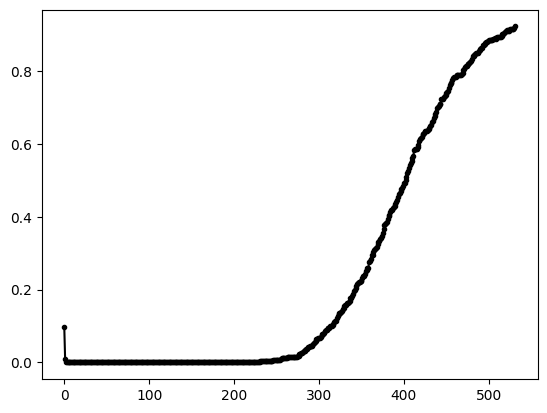

In [30]:
fig, ax=plt.subplots()
metric = 'traj_weight'
p_m = 0.095
L = 12
y = data_df.xs((metric, p_m, L), level = ('Metrics','p_m','L'))['observations'].iloc[0]
ax.plot( y, '.-', label=f'p={p_m}', color='k')

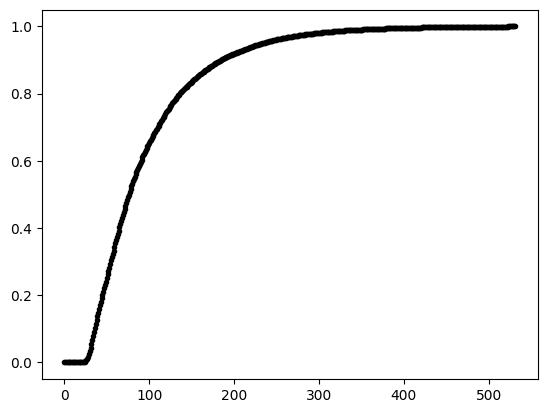

In [ ]:
fig, ax=plt.subplots()
metric = 'state_weight'
p_m = 0.09
L = 12
y = data_df.xs((metric, p_m, L), level = ('Metrics','p_m','L'))['observations'].iloc[0]
ax.plot( y, '.-', label=f'p={p_m}', color='k')

In [44]:
6*12**1.62

336.0662260513586

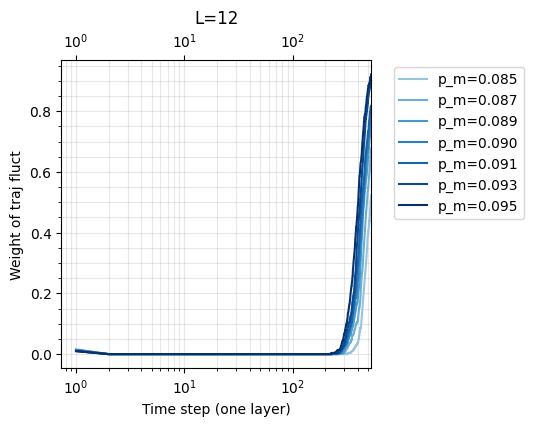

In [31]:
clifford_utils.plot_metric_T_vs_steps_fixedL( data_df, L=12, metric='traj_weight' ,ylabel='Weight of traj fluct',  ax=None, yscale='linear', p_m_list =None )


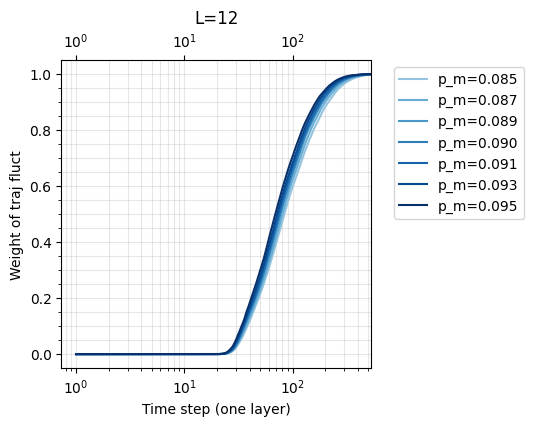

In [32]:
clifford_utils.plot_metric_T_vs_steps_fixedL( data_df, L=12, metric='state_weight' ,ylabel='Weight of traj fluct',  ax=None, yscale='linear', p_m_list =None )


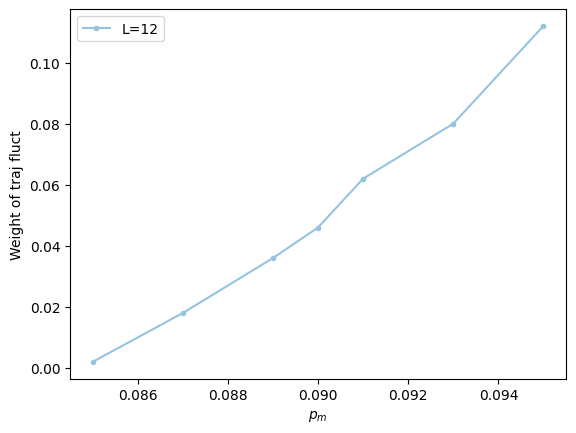

In [35]:
traj_weight=clifford_utils.plot_metric_T_vs_p(data_df, metric='traj_weight', min_func = lambda L: int(6.*L**1.6)-1, max_func = lambda L: int(6.*L**1.6)-0,  ylabel='Weight of traj fluct', L_list=L_list, )


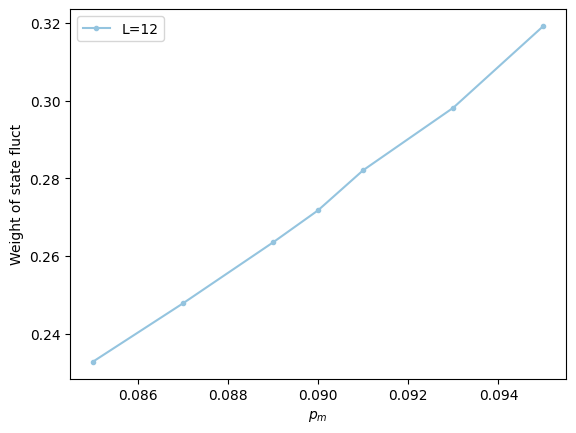

In [38]:
traj_weight=clifford_utils.plot_metric_T_vs_p(data_df, metric='state_weight', min_func = lambda L: int(1.*L**1.6)-1, max_func = lambda L: int(1.*L**1.6)-0,  ylabel='Weight of state fluct', L_list=L_list, )


In [ ]:
k